In [1]:
# Keras
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Model

#SciKit
from sklearn.metrics import confusion_matrix

#matplot
import matplotlib.pyplot as plt

#Numpy
import numpy as np

2023-10-10 22:02:53.725348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 22:02:53.879673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 22:02:53.879701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 22:02:53.880600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 22:02:53.967702: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 22:02:53.968458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Loading [Mnist](https://keras.io/api/datasets/mnist/) dataset

In [2]:

np.random.seed(123)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train/255
x_test =x_test/255

y_train_onehot = keras.utils.to_categorical(y_train, 10)
y_test_onehot = keras.utils.to_categorical(y_test, 10)

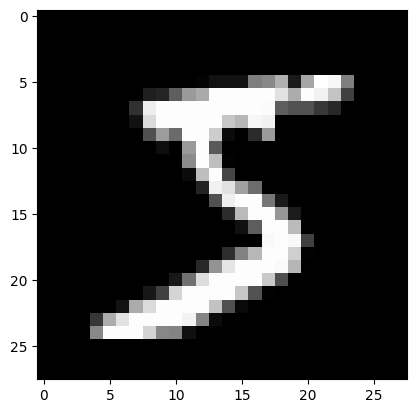

In [3]:
img = x_train[0]
plt.imshow(img, cmap='gray')
plt.show()

# LeNet

In [4]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [5]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

## Training Phase

In [6]:
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy', precision, recall])

model.fit(x_train, y_train_onehot,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.3912 - accuracy: 0.8856 - precision: 0.9367 - recall: 0.8364
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.1238 - accuracy: 0.9636 - precision: 0.9695 - recall: 0.9578
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0850 - accuracy: 0.9735 - precision: 0.9774 - recall: 0.9705
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0662 - accuracy: 0.9797 - precision: 0.9823 - recall: 0.9777
Epoch 5/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0555 - accuracy: 0.9833 - precision: 0.9853 - recall: 0.9817


## Test Phase

Evaluate

In [7]:
score = model.evaluate(x_test, y_test_onehot, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.9837 - precision: 0.9859 - recall: 0.9820


Confusion Matrix

In [8]:
ŷ = model.predict(x_test)
y_pred = [np.argmax(yi) for yi in ŷ]
confusion_matrix(y_test, y_pred)

313/313 [==============================] - 1s 2ms/step


array([[ 971,    0,    0,    0,    0,    1,    2,    3,    3,    0],
       [   0, 1129,    0,    0,    0,    1,    1,    0,    4,    0],
       [   6,   11,  982,    5,    1,    0,    2,   15,    9,    1],
       [   1,    0,    0,  997,    0,    4,    0,    5,    3,    0],
       [   1,    0,    1,    1,  963,    0,    4,    3,    0,    9],
       [   1,    0,    0,    2,    0,  887,    1,    1,    0,    0],
       [   4,    2,    0,    0,    1,    6,  944,    0,    1,    0],
       [   0,    3,    4,    1,    0,    0,    0, 1017,    1,    2],
       [   1,    0,    0,    4,    1,    3,    0,    5,  956,    4],
       [   1,    2,    0,    2,    2,    1,    1,    9,    0,  991]])

## Visualizing Feature maps

In [48]:
def visualizeFeatureMap(img, model, nth_layer):
    # visualize the feature map off input<img> at model<model> on convolution layer<nth_layer>

    # Create a model that will return these outputs, given the model input
    feature_map_model = Model(inputs=model.inputs, outputs=model.layers[nth_layer].output)

    # Use the model to predict the features
    feature_maps = feature_map_model.predict(
        img.reshape(1, img.shape[0], img.shape[1], img.shape[2] if len(img.shape)==3 else 1), verbose = 0)


    numOfFeatureMaps = model.layers[nth_layer].output.shape[3]
    gridAxisDim = np.int16(np.ceil(np.sqrt(numOfFeatureMaps)))
    for i in range(numOfFeatureMaps):
        plt.subplot(gridAxisDim, gridAxisDim, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.show()

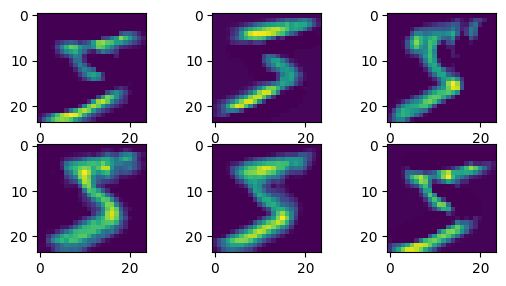

In [49]:
visualizeFeatureMap(img, model, 0)

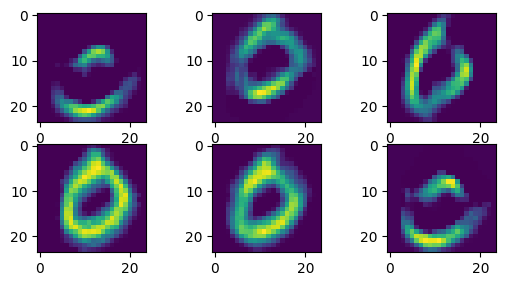

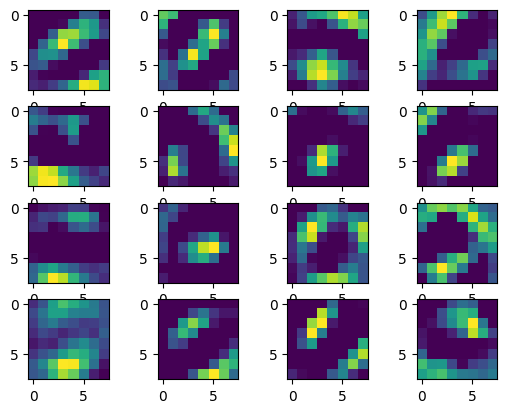

----------------------------------------------------------


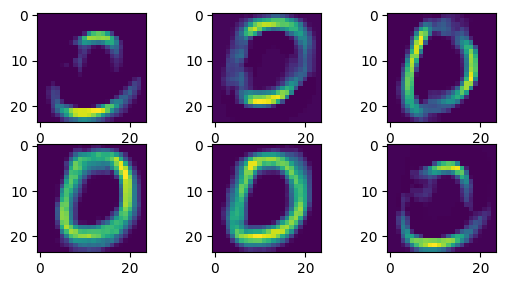

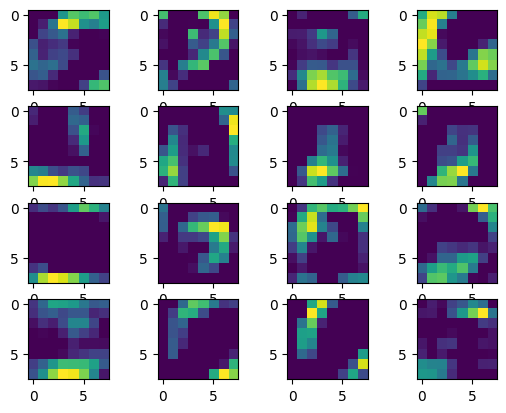

----------------------------------------------------------


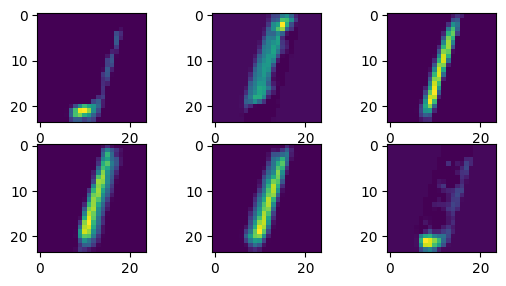

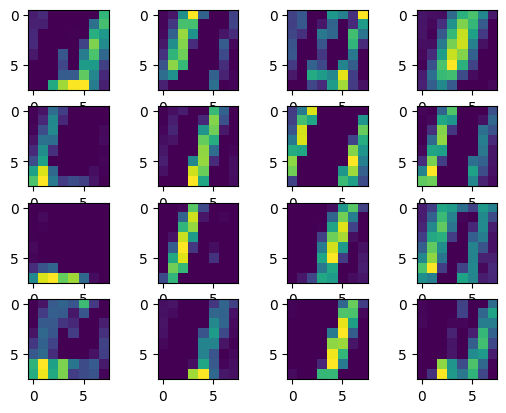

----------------------------------------------------------


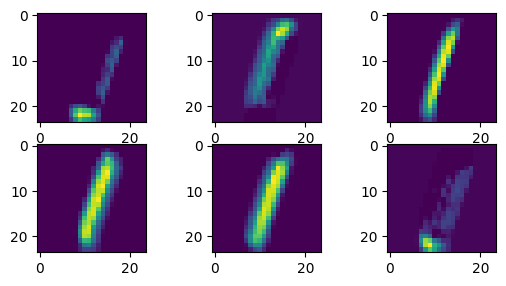

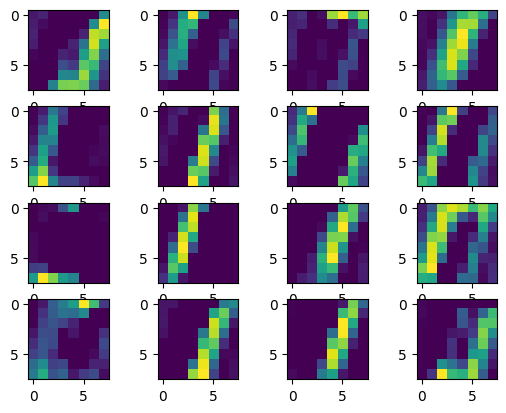

----------------------------------------------------------


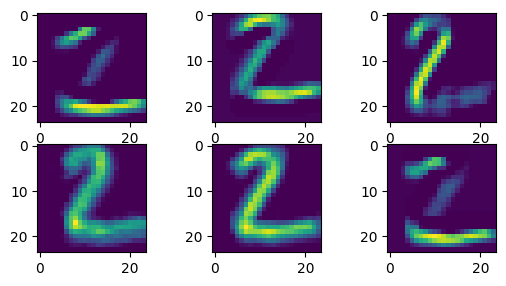

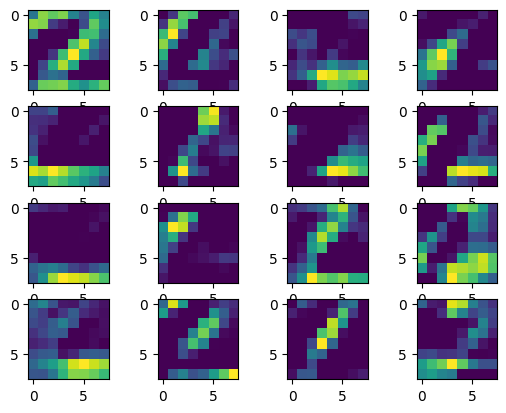

----------------------------------------------------------


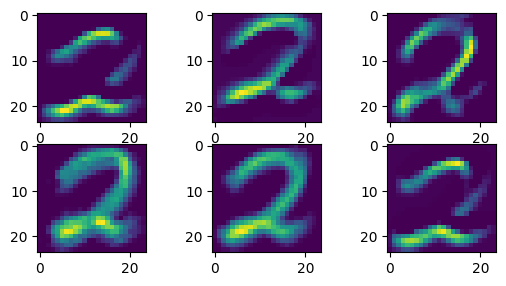

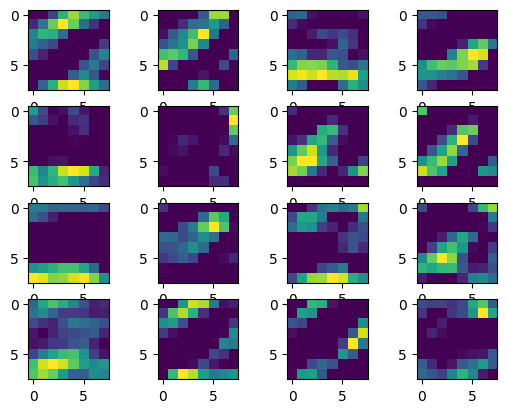

----------------------------------------------------------


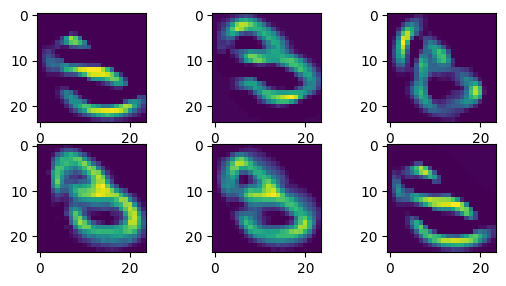

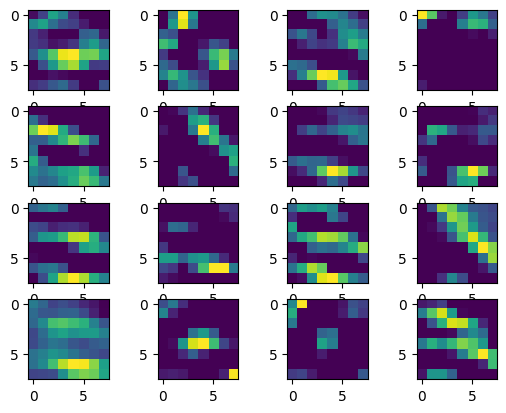

----------------------------------------------------------


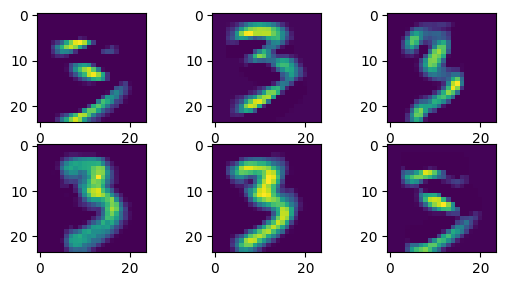

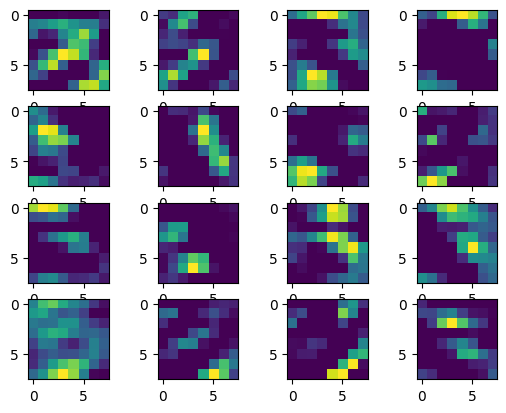

----------------------------------------------------------


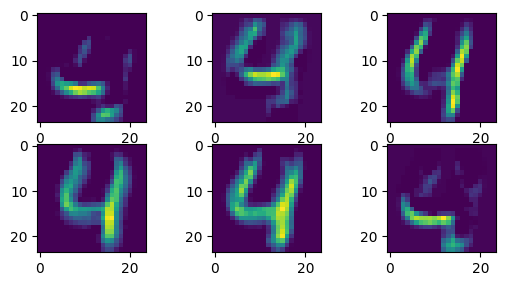

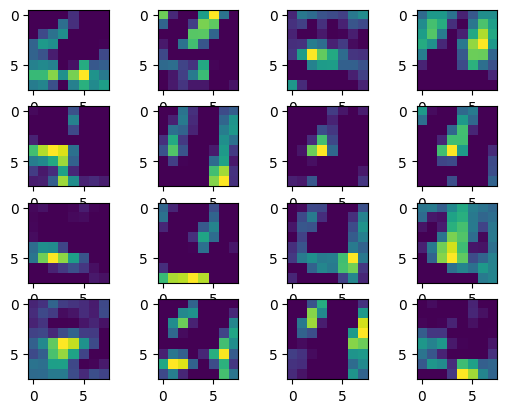

----------------------------------------------------------


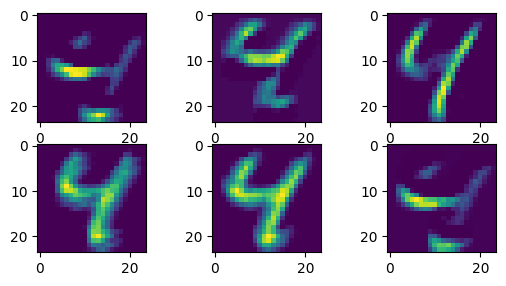

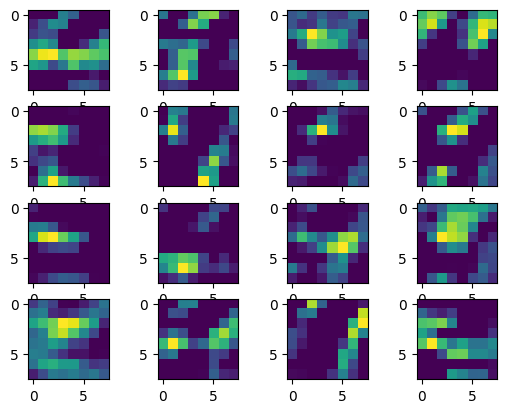

----------------------------------------------------------


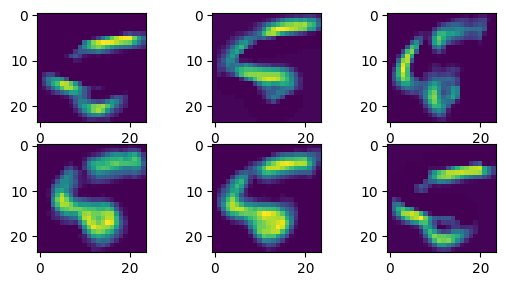

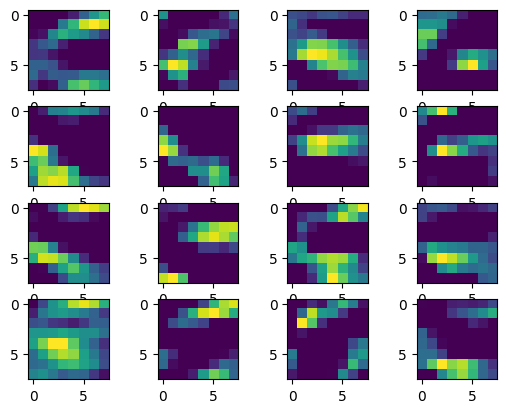

----------------------------------------------------------


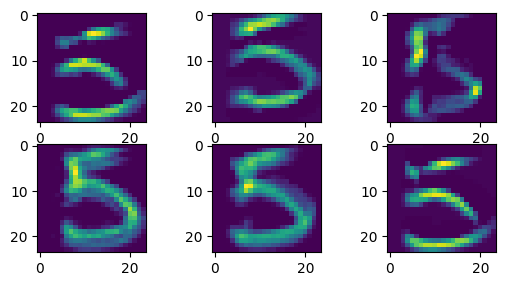

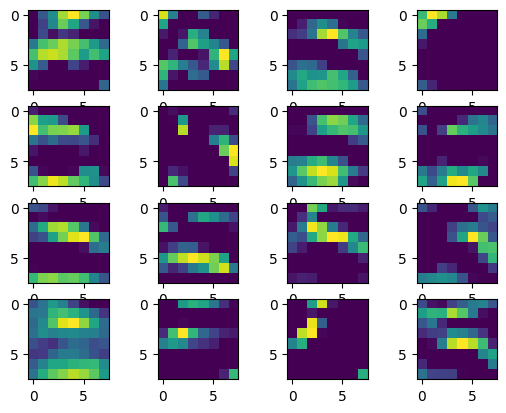

----------------------------------------------------------


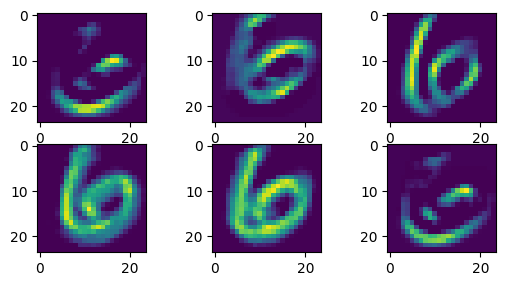

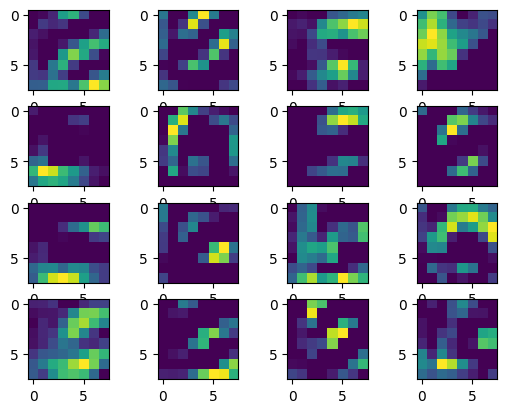

----------------------------------------------------------


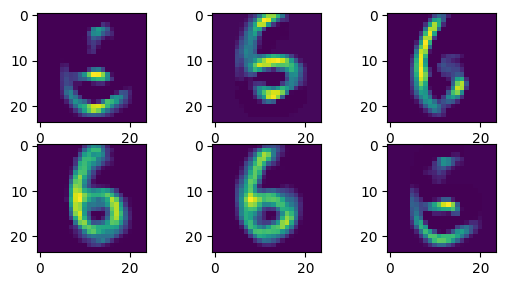

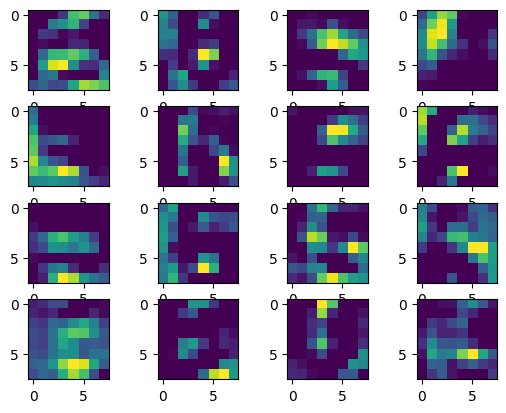

----------------------------------------------------------


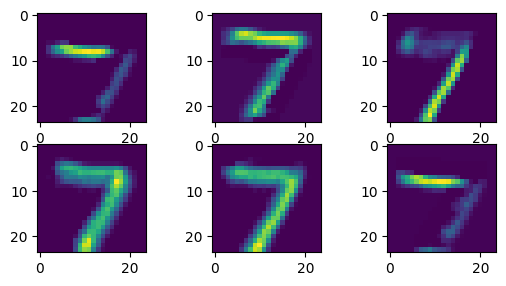

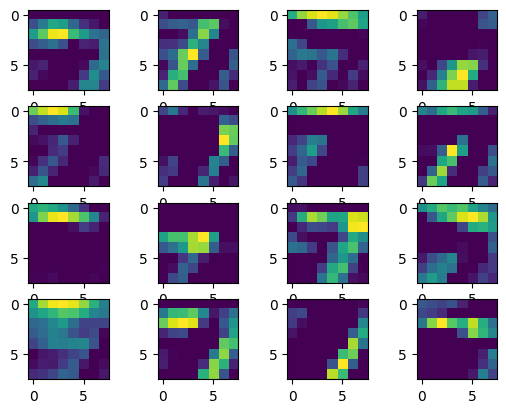

----------------------------------------------------------


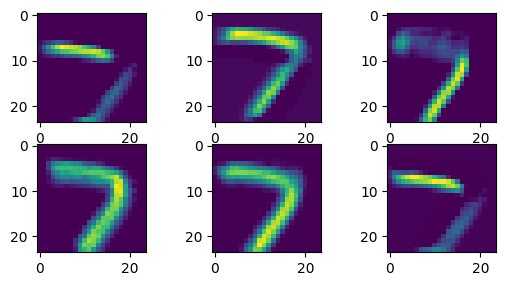

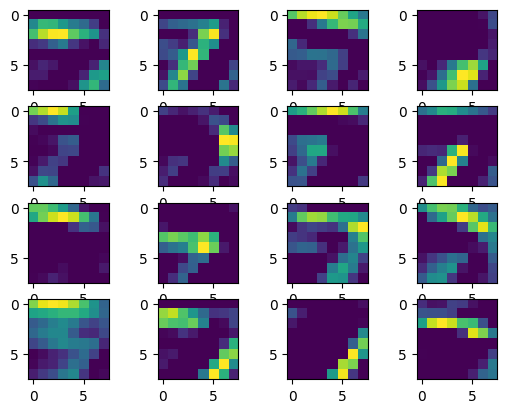

----------------------------------------------------------


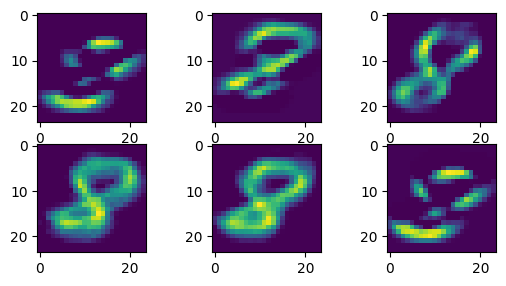

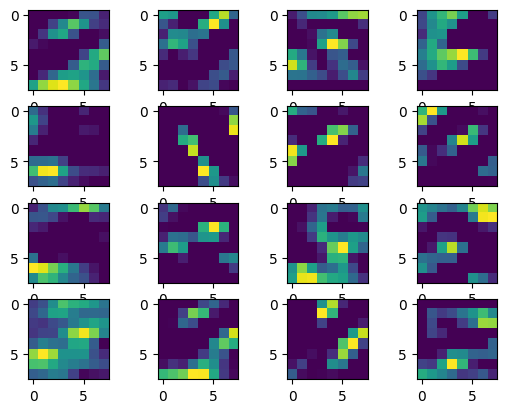

----------------------------------------------------------


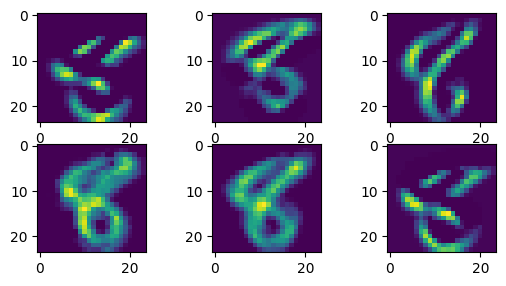

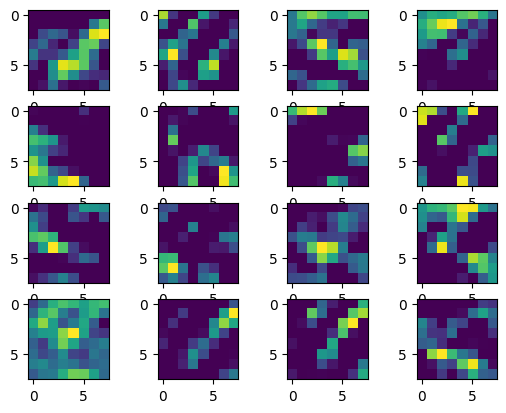

----------------------------------------------------------


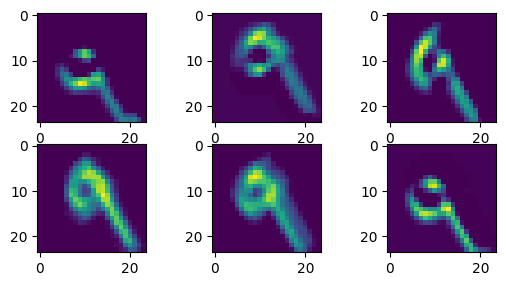

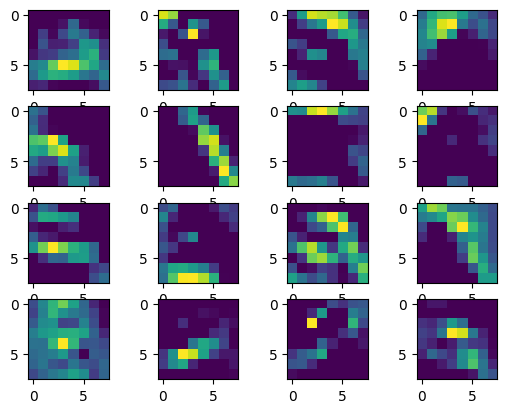

----------------------------------------------------------


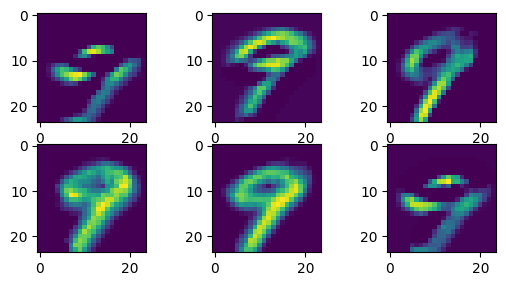

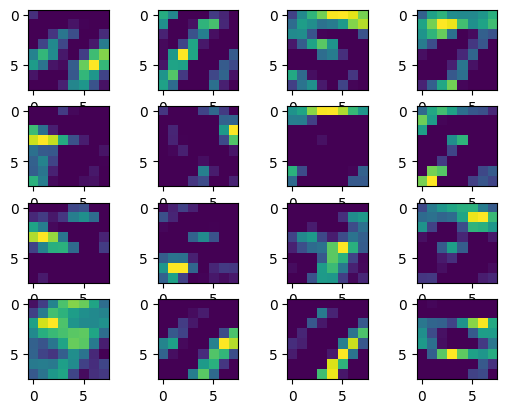

----------------------------------------------------------


In [52]:
for i in range(10):
    num = i
    filter = y_test == num

    x_test_num = x_test[filter]
    y_test_num = y_test[filter]

    visualizeFeatureMap(x_test_num[0], model, 0)
    visualizeFeatureMap(x_test_num[0], model, 2)
    print('----------------------------------------------------------')
    visualizeFeatureMap(x_test_num[1], model, 0)
    visualizeFeatureMap(x_test_num[1], model, 2)
    print('----------------------------------------------------------')


# Conclusion

The CNN LeNet aproach for MNIST classification problem proved to be better than MLP because the number of parameters.

LeNet has 44.426 parameters and my MLP approach has 1.024.080.

